# Emotion Detection via Voice 

**Importing the Necessary Libraries**

In [19]:
import os

#Data handling
import numpy as np
import random
import pandas as pd
from tqdm import tqdm  #Progress bar for loops




#udio processing
import librosa
import librosa.display
import soundfile as sf
import librosa.effects  # for time_stretch and pitch_shift

#Machine Learning / Deep Learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, 
    GlobalAveragePooling2D, Dense, Reshape, Bidirectional, LSTM, GaussianNoise
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#Visualization
import matplotlib.pyplot as plt
import seaborn as sn





**Dataset Setup**

In [2]:

# Path to dataset 
data_path = "/kaggle/input/cremad/AudioWAV"

# Collect all .wav audio files in the directory
all_files = [f for f in os.listdir(data_path) if f.endswith('.wav')]

print("Total audio files found:", len(all_files))

# Preview first 5 files instead of printing all
print("Sample files:", all_files[:5])

# Extract emotion labels from filenames
# Correct: Emotion is the 3rd element in filename pattern: XXX_XXX_EMOTION_XXX.wav
labels = [f.split('_')[2] for f in all_files]

# Create DataFrame for easier handling
data = pd.DataFrame({
    'file': all_files,
    'emotion': labels
})

# Display dataset info
print("\nDataset shape:", data.shape)
print("\nUnique emotions:", data['emotion'].unique())
print("\nEmotion distribution:")
print(data['emotion'].value_counts())


Total audio files found: 7442
Sample files: ['1028_TSI_DIS_XX.wav', '1075_IEO_HAP_LO.wav', '1084_ITS_HAP_XX.wav', '1067_IWW_DIS_XX.wav', '1066_TIE_DIS_XX.wav']

Dataset shape: (7442, 2)

Unique emotions: ['DIS' 'HAP' 'SAD' 'NEU' 'FEA' 'ANG']

Emotion distribution:
emotion
DIS    1271
HAP    1271
SAD    1271
FEA    1271
ANG    1271
NEU    1087
Name: count, dtype: int64


**Processing the Voices**

In [28]:
n_mfcc = 40
max_pad_len = 174

X = []
y = []

for _, row in tqdm(data.iterrows(), total=len(data)):
    file_path = os.path.join(data_path, row['file'])
    try:
        # Load audio
        signal, sr = librosa.load(file_path, sr=None)

        # MFCC + delta + delta-delta
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)

        # Stack → (120, time)
        mfcc_features = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

        # Pad/truncate
        if mfcc_features.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc_features.shape[1]
            mfcc_padded = np.pad(mfcc_features, ((0,0),(0,pad_width)), mode='constant')
        else:
            mfcc_padded = mfcc_features[:, :max_pad_len]

        # Normalize
        mfcc_norm = (mfcc_padded - np.mean(mfcc_padded)) / (np.std(mfcc_padded) + 1e-9)

        X.append(mfcc_norm)
        y.append(row['emotion'])

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")

X = np.array(X)
y = np.array(y)

# Add channel dimension → (samples, 120, 174, 1)
X = X[..., np.newaxis]

print("Final X shape:", X.shape)
print("Final y shape:", y.shape)
print("Unique emotions:", np.unique(y))

100%|██████████| 7442/7442 [01:25<00:00, 87.51it/s]


Final X shape: (7442, 120, 174, 1)
Final y shape: (7442,)
Unique emotions: ['DFA' 'IEO' 'IOM' 'ITH' 'ITS' 'IWL' 'IWW' 'MTI' 'TAI' 'TIE' 'TSI' 'WSI']


**Convert Emotion Labels into the Numeric**

In [29]:

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=len(np.unique(y_encoded)))

print("Shape of labels after encoding:", y_onehot.shape)
print("Classes:", le.classes_)



Shape of labels after encoding: (7442, 12)
Classes: ['DFA' 'IEO' 'IOM' 'ITH' 'ITS' 'IWL' 'IWW' 'MTI' 'TAI' 'TIE' 'TSI' 'WSI']


**Split the Dataset in the train and test**

In [30]:


X_train, X_val, y_train, y_val = train_test_split(
    X, y_onehot,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded  # ensures balanced class distribution
)

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)


Training data shape: (5953, 120, 174, 1) (5953, 12)
Validation data shape: (1489, 120, 174, 1) (1489, 12)


**Building the CNN Model**

In [31]:
model = Sequential()

# Input + Noise
model.add(Input(shape=(40, 174, 1)))
model.add(GaussianNoise(0.05))

# --- Deeper CNN backbone ---
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.35))

# Global pooling
model.add(GlobalAveragePooling2D())

# --- LSTM block ---
model.add(Reshape((8, -1)))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.2)))
model.add(Dropout(0.4))

# --- Dense layers ---
model.add(Dense(128, activation='relu'))  # reduced size
model.add(Dropout(0.4))

# Output layer
model.add(Dense(y_onehot.shape[1], activation='softmax'))

# Compile with label smoothing
optimizer = Adam(learning_rate=0.0001)
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_3                │ (None, 40, 174, 1)     │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 40, 174, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 40, 174, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 20, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 20, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 20, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 20, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 10, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 10, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 10, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 10, 43, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 21, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 5, 21, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 5, 21, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 5, 21, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 2, 10, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 2, 10, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       164,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,89

 Total params: 589,068 (2.25 MB)

 Trainable params: 588,108 (2.24 MB)

 Non-trainable params: 960 (3.75 KB)

**Train the Model**

Epoch 1/120


E0000 00:00:1756067614.507254      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_5_1/dropout_27_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.1305 - loss: 2.4888
Epoch 1: val_accuracy improved from -inf to 0.19610, saving model to voice_emotion_best.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 32s 105ms/step - accuracy: 0.1307 - loss: 2.4887 - val_accuracy: 0.1961 - val_loss: 2.4376 - learning_rate: 1.0000e-04
Epoch 2/120
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.1978 - loss: 2.4067
Epoch 2: val_accuracy did not improve from 0.19610
187/187 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.1978 - loss: 2.4067 - val_accuracy: 0.1961 - val_loss: 2.8002 - learning_rate: 1.0000e-04
Epoch 3/120
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2061 - loss: 2.3641
Epoch 3: val_accuracy did not improve from 0.19610
187/187 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.2061 - loss: 2.3640 - val_accuracy: 0.1961 - val_loss: 3.7079 - learning_rate: 1.0000e-04
Epoch 4/120
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2491 - loss: 2.2655
Epoch 4: val_accuracy 

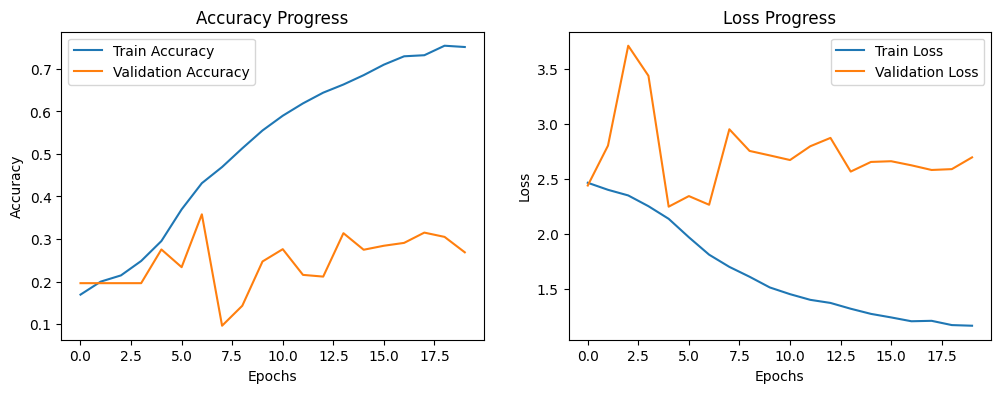

In [32]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,              # more patience to let val_acc improve
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'voice_emotion_best.keras',
    monitor='val_accuracy',   # save based on validation accuracy
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=120,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

# Plot history
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Progress')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Accuracy of Model**

In [33]:
#✅ Print final accuracy and loss in percentage
final_train_acc = history.history['accuracy'][-1] * 100
final_val_acc = history.history['val_accuracy'][-1] * 100
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"✅ Final Training Accuracy: {final_train_acc:.2f}%")
print(f"✅ Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"📉 Final Training Loss: {final_train_loss:.4f}")
print(f"📉 Final Validation Loss: {final_val_loss:.4f}")
# ✅ Save model in multiple formats

✅ Final Training Accuracy: 75.14%
✅ Final Validation Accuracy: 26.86%
📉 Final Training Loss: 1.1636
📉 Final Validation Loss: 2.6935


In [35]:

# (works with TensorFlow 2.18.0 / Keras 3.8.0)

# Save full model in new .keras format (recommended)
model.save("voice_emotion_model.keras")

# Save full model in legacy .h5 format (architecture + weights together)
model.save("voice_emotion_model.h5")

# Save architecture only
with open("model_architecture.json", "w") as f:
    f.write(model.to_json())

# Save weights only
model.save_weights("model_weights.weights.h5")

print("✅ Model saved in .keras, .h5, .json, and .weights.h5 formats")





✅ Model saved in .keras, .h5, .json, and .weights.h5 formats


**Saving the Necessary files for GUI**

In [34]:
import tensorflow as tf, keras, numpy, librosa, sklearn
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
import numpy
print("NumPy:", numpy.__version__)
import librosa
print("Librosa:", librosa.__version__)
import sklearn
print("Scikit-learn:", sklearn.__version__)


TensorFlow: 2.18.0
Keras: 3.8.0
NumPy: 1.26.4
Librosa: 0.11.0
Scikit-learn: 1.2.2
